In [188]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import joblib

In [189]:
df = pd.read_csv('../Data/cleaned-premier-onehot.csv')

## Using Random forest model

In [190]:
def get_outcome(row):
    if row["home_outcome_W"] == 1:
        return 2  # win
    elif row["home_outcome_D"] == 1:
        return 1  # draw
    elif row["home_outcome_L"] == 1:
        return 0  # loss

df["match_result"] = df.apply(get_outcome, axis=1)

### Making new feature to help prediction

In [191]:
df["ranking_diff"] = abs(df["home_ranking"] - df["away_ranking"])

df["form_diff"] = abs(
    (df["home_season_wins_so_far"] - df["home_season_losses_so_far"]) -
    (df["away_season_wins_so_far"] - df["away_season_losses_so_far"])
)
df["odds_ratio"] = df["avg_odd_home_win"] / df["avg_odd_away_win"]

df["draw_margin"] = df["avg_odd_draw"] - ((df["avg_odd_home_win"] + df["avg_odd_away_win"]) / 2)

df["is_balanced_match"] = (
    (df["ranking_diff"].abs() <= 2) &
    (df["form_diff"].abs() <= 2)
).astype(int)

In [192]:
features = [
    "avg_odd_home_win", "avg_odd_draw", "avg_odd_away_win",
    "home_ranking", "away_ranking",
    "home_season_wins_so_far", "home_season_draws_so_far", "home_season_losses_so_far",
    "away_season_wins_so_far", "away_season_draws_so_far", "away_season_losses_so_far",
    "form_diff", "ranking_diff", "odds_ratio", "draw_margin",
]

### scale the data

In [193]:
X = df[features]
y = df["match_result"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Train the model

In [194]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [195]:
model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight="balanced",
    random_state=42
)

# 🧠 Train
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

## validate the model

In [196]:
print("\nFeatures used:")
for f in features:
    print(" -", f)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

labels = [0, 1, 2]
names = ["loss", "draw", "win"]    

print("\nClassification Report:")
print(classification_report(y_test, y_pred, labels=labels, target_names=names))


Features used:
 - avg_odd_home_win
 - avg_odd_draw
 - avg_odd_away_win
 - home_ranking
 - away_ranking
 - home_season_wins_so_far
 - home_season_draws_so_far
 - home_season_losses_so_far
 - away_season_wins_so_far
 - away_season_draws_so_far
 - away_season_losses_so_far
 - form_diff
 - ranking_diff
 - odds_ratio
 - draw_margin

Confusion Matrix:
[[33 14 29]
 [14 13 38]
 [16 10 83]]

Classification Report:
              precision    recall  f1-score   support

        loss       0.52      0.43      0.47        76
        draw       0.35      0.20      0.25        65
         win       0.55      0.76      0.64       109

    accuracy                           0.52       250
   macro avg       0.48      0.47      0.46       250
weighted avg       0.49      0.52      0.49       250



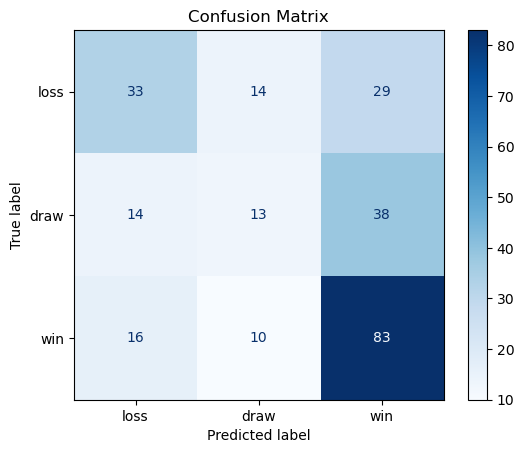

In [197]:
# Define label names
labels = [0, 1, 2]
names = ["loss", "draw", "win"]

# Plot confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=names,
    cmap=plt.cm.Blues,
    normalize=None
)

plt.title("Confusion Matrix")
plt.show()



Feature Importances (Random Forest):
avg_odd_home_win               0.0908
avg_odd_draw                   0.0859
avg_odd_away_win               0.1035
home_ranking                   0.0647
away_ranking                   0.0596
home_season_wins_so_far        0.0510
home_season_draws_so_far       0.0492
home_season_losses_so_far      0.0517
away_season_wins_so_far        0.0514
away_season_draws_so_far       0.0482
away_season_losses_so_far      0.0503
form_diff                      0.0508
ranking_diff                   0.0592
odds_ratio                     0.0997
draw_margin                    0.0840


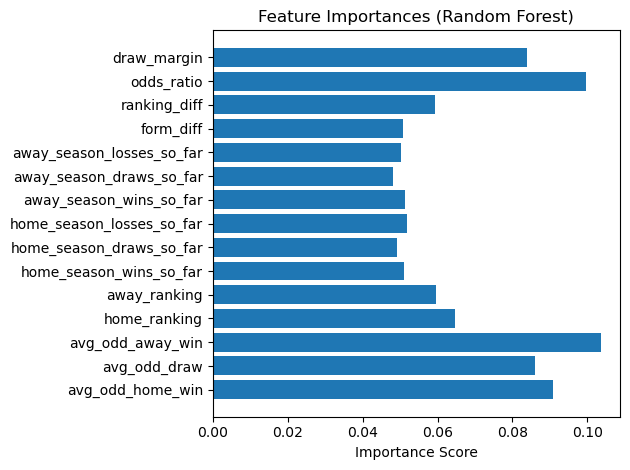

In [198]:
importances = model.feature_importances_

print("\nFeature Importances (Random Forest):")
for feat, score in zip(features, importances):
    print(f"{feat:<30} {score:.4f}")

plt.barh(features, importances)
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

### Model Behavior Analysis

In [199]:
joblib.dump(model, '../Models/random-forest2-model.pkl')

['../Models/random-forest2-model.pkl']